# 1 Введение

## 1.1 Постановка задачи

**Заказчик** -- компания, предоставляющая услуги такси  
  
**Задача** -- построить модель предсказания количества заказов такси на следующий час в аэропортах. Значение метрики RMSE на тестовой выборке должно быть не больше 48

## 1.2 Исходные данные

### 1.2.1 Общее описание
Компания собрала исторические данные о заказах такси в аэропортах

### 1.2.2 Переданные файлы
- taxi.csv

### 1.2.3 Описание данных
Количество заказов находится в столбце 'num_orders'

## 1.3 План обработки и анализа данных

### 1.3.1 Предобработка данных
- обзор данных;
- корректировка имён столбцов (при необходимости);
- удаление дубликатов строк;
- ресемплирование данных по одному часу;
- проверка на мотонность.

### 1.3.2 Анализ данных
Поиск сезонности и трендов

### 1.3.3 Обучение моделей ML
#### 1.3.3.1 Линейная регрессия
#### 1.3.3.2 Случайный лес
#### 1.3.3.3 CatBoost

### 1.3.4 Тестирование моделей
#### 1.3.4.1 Линейная регрессия
#### 1.3.4.2 Случайный лес
#### 1.3.4.3 CatBoost

### 1.3.5 Вывод

## 1.4 Пользовательские функции

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 10
#pd.options.display.max_columns = 50
pd.options.mode.chained_assignment = None

# 2 Основная часть

## 2.1 Предобработка данных

**Обзор данных**

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


**Проверка на мотонность**

In [5]:
data.index.is_monotonic

True

**Ресемплирование данных по одному часу**

In [6]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

***Промежуточный вывод***  
  
В ходе предобработки данных:
- столбец *datetime* во время загрузки данных был преобразоват в тип *datetime* и задан, как ключевой (индексовый);
- пропуски в данных отсутствуют;
- данные ключевого поля монотонно увеличиваются с шагом 10 минут;
- данные были ресемплированы на шаг в 1 час.

### 2.2 Анализ данных
**Поиск сезонности и трендов**

In [7]:
figsize = (16,5)

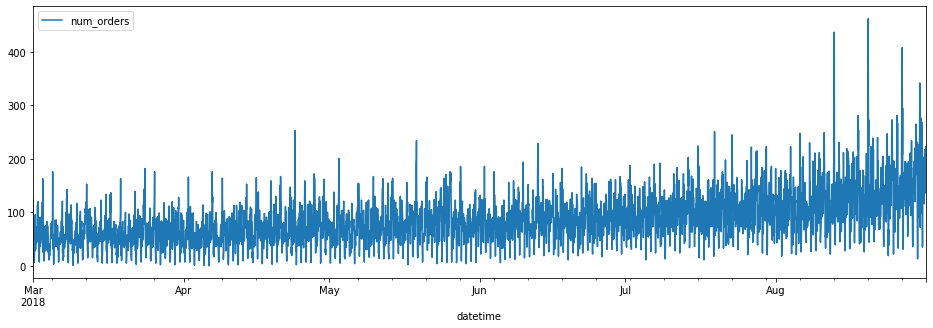

In [8]:
data.plot(figsize=figsize)

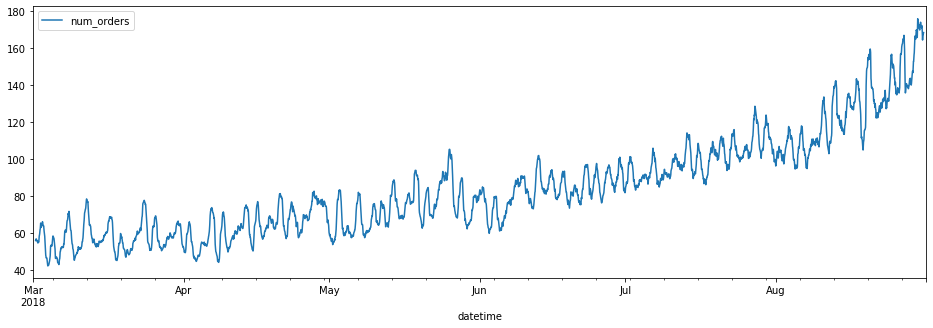

In [9]:
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-08-31']
decomposed.trend.plot(figsize=figsize)

В переданных данных прослеживается явный возрастающий тренд, что говорит о том, что дела у "Чётенького такси" в 2018 году шли в гору -- общее количество заказов расло

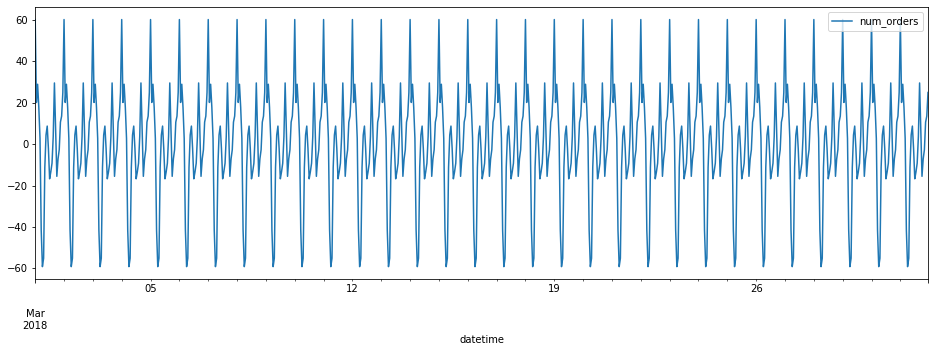

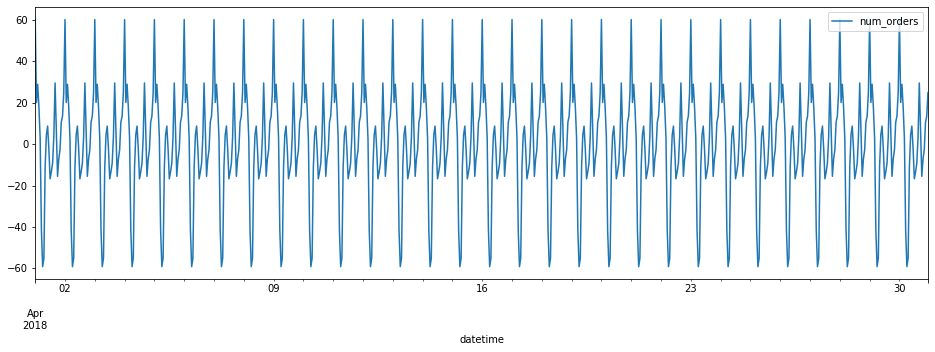

In [10]:
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(figsize=figsize)
decomposed.seasonal['2018-04-01':'2018-04-30'].plot(figsize=figsize)

Месячной сезонности не наблюдается, поскольку периодичность повторов данных имеет шаг явно меньше месяца

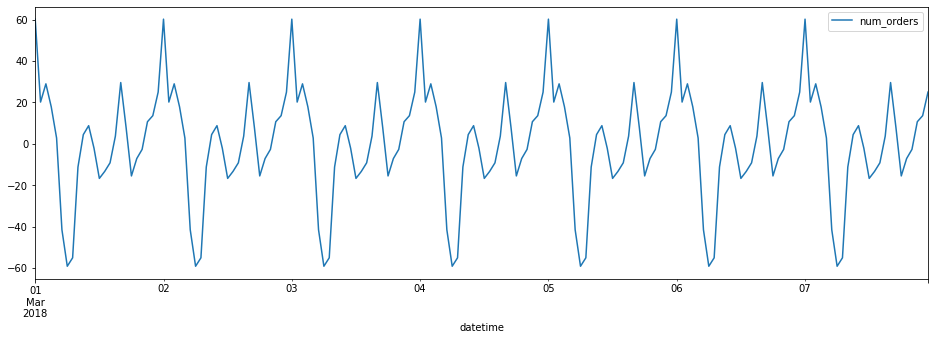

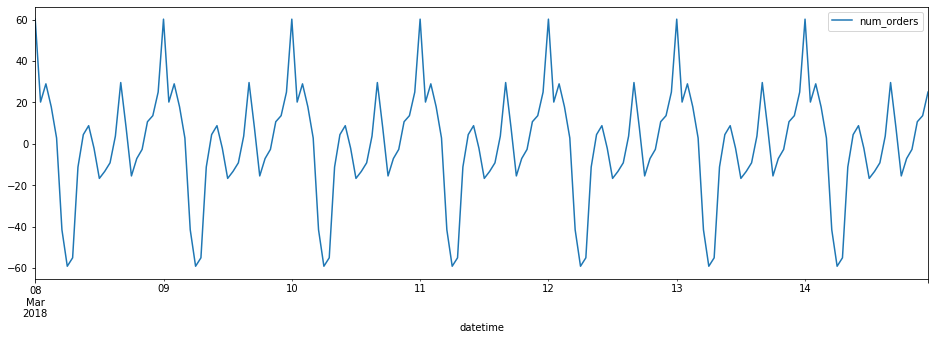

In [11]:
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(figsize=figsize)
decomposed.seasonal['2018-03-08':'2018-03-14'].plot(figsize=figsize)

Недельной сезонности также не наблюдается

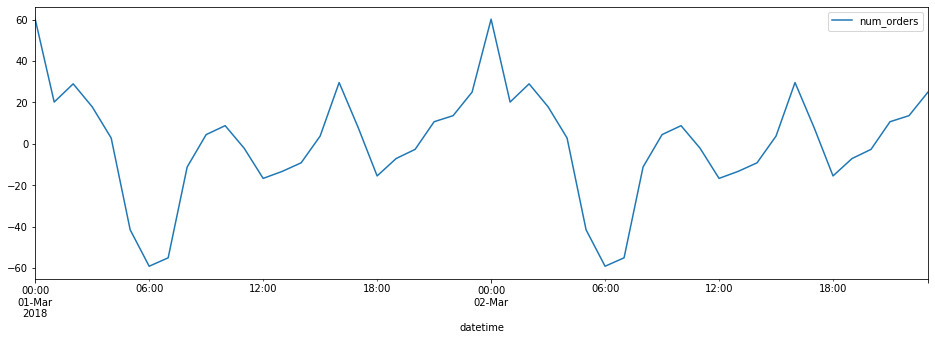

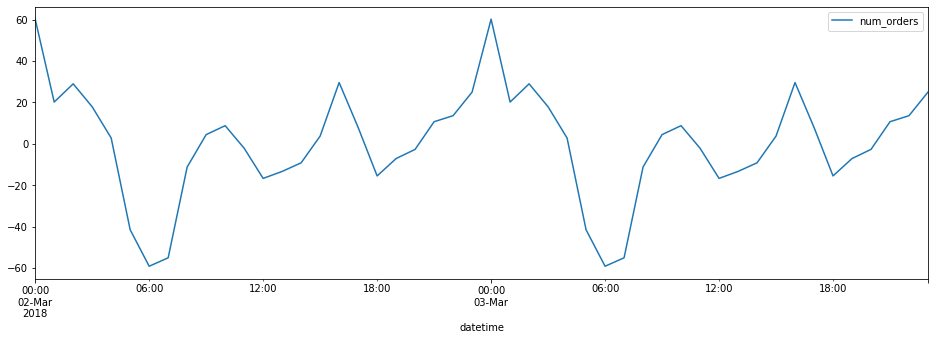

In [12]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(figsize=figsize)
decomposed.seasonal['2018-03-02':'2018-03-03'].plot(figsize=figsize)

Дневная сезонность ярко выражена. Похоже "Чётенькое такси" работает в аэропорте, в котором спрос на такси не зваисит от времени года. В Москве, наверное

***Промежуточный вывод***  
  
По итогам проведённого анализа можно сделать следующие выводы:

- восходящий тренд ярко выражен на отрезке времени в один год;
- сезонность данных не выражена на отрезках в месяц и неделю;
- сезонность ярко выражена на отрезке в день.

## 2.3 Обучение моделей ML

### 2.3.1 Разделение набора данных на выборки

**Добавление признаков**  
Поскольку дата используется только в качестве индекса, часть полезной информации теряется. Добавим день, месяц и год в набор данных из индекса

In [13]:
data['year'] = data.index.year
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek

**Добавление смещений и скользящего среднего значения**  
Количество смещений примем равным длине сезона -- 24

In [14]:
for lag in range(1, 24 + 1):
    data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(24).mean()

In [15]:
data=data.dropna()

**Выделение обучающей, валидационной и тестовой выборок**

In [16]:
train_data, valid_data = train_test_split(data, shuffle=False, test_size=0.2)
valid_data, test_data = train_test_split(valid_data, shuffle=False, test_size=0.5)

target_train = train_data['num_orders']
features_train = train_data.drop('num_orders', axis=1)

target_valid = valid_data['num_orders']
features_valid = valid_data.drop('num_orders', axis=1)

target_test = test_data['num_orders']
features_test = test_data.drop('num_orders', axis=1)

### 2.3.2 Линейная регрессия

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
logreg_model = LinearRegression(normalize=True)
logreg_model.fit(features_train, target_train)
print('RMSE:', mean_squared_error(target_valid, logreg_model.predict(features_valid)) **0.5)

RMSE: 34.147239106124324


### 2.3.3 Случайный лес

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
random_forest_model = RandomForestRegressor(random_state=42)

param_grid = { 
    'n_estimators': [10, 50, 100, 150],
    'max_depth' : [1, 2, 3, 4, 5, 6, 7]}

CV_result = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5)

CV_result.fit(features_train, target_train)

CV_result.best_params_

{'max_depth': 7, 'n_estimators': 150}

In [21]:
random_forest_model = RandomForestRegressor(max_depth=7, n_estimators=150, random_state = 1457)
random_forest_model.fit(features_train, target_train)
print('RMSE:', mean_squared_error(target_valid, random_forest_model.predict(features_valid))**0.5)

RMSE: 35.53678353155889


### 2.3.4 CatBoost

In [22]:
from catboost import CatBoostRegressor

In [23]:
catboost_model = CatBoostRegressor(verbose=False)

param_grid = {'learning_rate': [0.03, 0.05, 0.1],
              'depth': [6, 8],
              'iterations': [10, 500]}

CV_result = GridSearchCV(estimator=catboost_model, param_grid=param_grid, cv=5)

CV_result.fit(features_train, target_train)
CV_result.best_params_

{'depth': 8, 'iterations': 500, 'learning_rate': 0.05}

In [24]:
catboost_model = CatBoostRegressor(learning_rate=0.05, depth=8, iterations=500, verbose=False)
catboost_model.fit(features_train, target_train)
print("RMSE:", mean_squared_error(target_valid, catboost_model.predict(features_valid))**0.5)

RMSE: 32.7256538720915


***Промежуточный вывод***  
  
По итогам обучения моделей ML можно сделать следующие выводы:
- для обучения моделей исходный набор данных был дополнен признаками *year*, *month*, *day*, *dayofweek*, скользящим среднем и смещениями в количестве 24 -- по размеру суточного сезона;
- дополненный набор данных был разделён на обучающую, валидационную и тестовые выборки в соотношении 8/1/1;
- на полученном обучающем наборе данных были обучены модели ML:
 - линейной регрессии;
 - случайного леса;
 - CatBoost;
- качество полученных моделей удовлетворяет предъявляемым требованиям -- RMSE < 48.

## 2.4 Тестирование моделей

### 2.4.1 Линейная регрессия

In [25]:
print('RMSE:', mean_squared_error(target_test, logreg_model.predict(features_test)) **0.5)

RMSE: 46.15789590843983


### 2.4.2 Случайный лес

In [26]:
print('RMSE:', mean_squared_error(target_test, random_forest_model.predict(features_test))**0.5)

RMSE: 54.217184927019574


### 2.4.3 CatBoost

In [27]:
print("RMSE:", mean_squared_error(target_test, catboost_model.predict(features_test))**0.5)

RMSE: 53.89976676982499


***Промежуточный вывод***  
  
По итогам тестирования моделей ML можно сделать вывод, что предъявляемому качеству соответствует только модель линейной ргрессии. Для улучшения качества моделий случайнго леса и CatBoost необходимо проводить их параметрическую оптимизацию

# 3 Вывод

В ходе выполнения работы было сделано следующее.  
  
В ходе предобработки данных:
- столбец *datetime* во время загрузки данных был преобразоват в тип *datetime* и задан, как ключевой (индексовый);
- был сделан вывод, что пропуски в данных отсутствуют;
- было установлено, что данные ключевого поля монотонно увеличиваются с шагом 10 минут;
- данные были ресемплированы на шаг в 1 час.
  
По итогам проведённого анализа были сделаны следующие выводы:

- восходящий тренд ярко выражен на отрезке времени в один год;
- сезонность данных не выражена на отрезках в месяц и неделю;
- сезонность ярко выражена на отрезке в день.
  
Затем, на этапе обучения моделей ML было сделано следующее:
- для обучения моделей исходный набор данных был дополнен признаками *year*, *month*, *day*, *dayofweek*, скользящим среднем и смещениями в количестве 24 -- по размеру суточного сезона;
- дополненный набор данных был разделён на обучающую, валидационную и тестовые выборки в соотношении 8/1/1;
- на полученном обучающем наборе данных были обучены модели ML:
 - линейной регрессии;
 - случайного леса;
 - CatBoost;
- качество полученных моделей удовлетворяет предъявляемым требованиям -- RMSE < 48.
  
Затем полученные модели были протестированы на тестовой выборке. По итогам тестирования моделей ML был сделан вывод, что предъявляемому качеству соответствует только полученная модель *линейной ргрессии*. Для улучшения качества моделий *случайнго леса* и *CatBoost* необходимо проводить их параметрическую оптимизацию.
  
***Таким образом, для предсказания количества заказов такси на следующий час в аэропортах Заказчику необходимо использовать из полученных модель линейной регресии.***